In [53]:
from braindecode.preprocessing import (
    exponential_moving_standardize,
    preprocess,
    Preprocessor)
from numpy import multiply
from braindecode.datasets import MOABBDataset
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.util import set_random_seeds

from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd
from sklearn.metrics import confusion_matrix
from braindecode.visualization import plot_confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal


import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math
import wandb
import os
import neptune.new.integrations.sklearn as npt_utils
import neptune.new as neptune



os.environ['http_proxy'] = "http://192.41.170.23:3128"
os.environ['https_proxy'] = "http://192.41.170.23:3128"

from braindecode.models import ShallowFBCSPNet, Deep4Net ,HybridNet,EEGInceptionMI,EEGITNet,ATCNet

In [54]:
def create_dataloader(X, y, batch_size):
    X_tensor = torch.tensor(X).float()
    y_tensor = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_tensor, y_tensor)
    dl = torch.utils.data.DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)
    return dl

def early_stopping(train_loss, validation_loss, min_delta, tolerance):
    counter = 0
    if (validation_loss - train_loss) > min_delta:
        counter +=1
        if counter >= tolerance:
          return True

def extrack_dataset(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    #X2 = X[:, 7:8, :]
    #X3= X[:, 11:12, :]
    #(288, 22, 1125)
    #X = np.concatenate((X2,X3), axis=1)
    print(X.shape)

    #X = X.reshape(y_shape,X.shape[2],X.shape[1])
    return X,np.array(y_).T


def extrack_dataset_2class(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    return X_,y_for_2class

def extrack_dataset_2class_cut(dataset):
    for x, y, window_ind in dataset:
        x_shape = x.shape
        y_shape = len(dataset.get_metadata().target)
        break
    X = np.zeros((y_shape,x_shape[0],x_shape[1]))
    y_=[]
    i=0
    for x, y, window_ind in dataset:
        X[i]=x
        y_.append(y)
        i+=1
    y = np.array(y_).T
    X_ = np.zeros((int(y_shape/2) ,x_shape[0],x_shape[1])) #for 2 class
    y_for_2class =[]
    j=0
    for i in range(y.shape[0]):
        if y[i] == 0 or y[i] == 1:
            y_for_2class.append(y[i])
            X_[j]=X[i]
            j +=1
    y_for_2class = np.array(y_for_2class).T
    X_ = X_.reshape(y_for_2class.shape[0],X_.shape[2],X_.shape[1])
    #100, 1, 576, 22
    X_ = X_[:,64:320,:]
    print(X_.shape)
    return X_,y_for_2class


def train(model,gpu_num,train_loader,test_loader,
          weights_name=False,
          optimizer = None,
          criterion = None,
          num_epochs=500,
          vail_loader= None,
          save_weights = False,
          neptune = True,
          lr = None
         ):

    # Train the model


    train_loss = []
    valid_loss = [10,11]
    train_accuracy = []
    valid_accuracy = []

    old_loss = 100
    old_acc = 0
    valid_loss_vail = []


    for epoch in range(num_epochs):
        iter_loss = 0.0
        correct = 0
        iterations = 0

        model.train()

        for i, (items, classes) in enumerate(train_loader):
            items = Variable(items)
            classes = classes.type(torch.LongTensor)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)

            optimizer.zero_grad()
            outputs = model(items)

            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])
            #print(avg_pedic.shape)
            #print(classes.shape)
            loss = criterion(outputs, classes)

            iter_loss += loss.item()
            loss.backward()
            optimizer.step()

            metrics = {"train/train_loss": loss}

            #print(loss)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == classes.data).sum()
            iterations += 1

        train_loss.append(iter_loss/iterations)


        train_accuracy.append(( correct.float() / len(train_loader.dataset)))
        train_metrics = {"train/train_loss": iter_loss/iterations,
                       "train/train_accuracy": (100 * correct.float() / len(train_loader.dataset))}



        loss = 0.0
        correct = 0
        iterations = 0

        model.eval()

        for i, (items, classes) in enumerate(test_loader):
            classes = classes.type(torch.LongTensor)
            items = Variable(items)
            classes = Variable(classes)

            if cuda.is_available():
                items = items.cuda(gpu_num)
                classes = classes.cuda(gpu_num)


            outputs = model(items)
            #avg_pedic = torch.mean(outputs, 1, True).float()
            #avg_pedic = avg_pedic.reshape(classes.shape[0])

            loss += criterion(outputs, classes).item()

            _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == classes.data).sum()
            #print("correct : {}".format(classes.data))
            #print("predicted : {}".format(predicted))
            iterations += 1

        valid_loss.append(loss/iterations)
        correct_scalar = np.array([correct.clone().cpu()])[0]
        valid_accuracy.append(correct_scalar / len(test_loader.dataset) )

        test_metrics = {"Test/Test_loss": loss/iterations,
                       "Test/Test_accuracy": correct_scalar / len(test_loader.dataset) }

        if save_weights is True:
            if epoch+1 > 2 and valid_loss[-1] < old_loss and old_acc <= valid_accuracy[-1] :
                    newpath = r'./{}'.format(weights_name)
                    if not os.path.exists(newpath):
                        os.makedirs(newpath)
                    torch.save(model.state_dict(),'./{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1]))
                    part_weights = './{}/{:.4f}_{}_{:.4f}_{:.4f}'.format(weights_name,valid_loss[-1],weights_name,valid_loss[-1],valid_accuracy[-1])
                    old_loss = valid_loss[-1]
                    old_acc = valid_accuracy[-1]

        print ('Epoch %d/%d, Tr Loss: %.4f, Tr Acc: %.4f, Val Loss: %.4f, Val Acc: %.4f , le : %f'
                       %(epoch+1, num_epochs, train_loss[-1], train_accuracy[-1], valid_loss[-1], valid_accuracy[-1],lr))
        if early_stopping(train_loss[-1], valid_loss[-1], min_delta=10, tolerance = 20):
            print("We are at epoch:", epoch+1)
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])

            break
        if neptune is True:
            run[f"epoch/valid_accuracy"].append(valid_accuracy[-1])
            run[f"epoch/train_accuracy"].append(train_accuracy[-1])
            run[f"epoch/train_loss"].append(train_loss[-1])
            run[f"epoch/valid_loss"].append(valid_loss[-1])
        if epoch+1 == 1:
            stop_loss = valid_loss[-1]

        if  (epoch+1)//500 == 0 and epoch+1 > 1400 :
            if valid_loss[-1] > valid_loss[-500]:
                print("Stop")
                break

    return train_loss,valid_loss,train_accuracy,valid_accuracy,part_weights
def eval(model,
         gpu_num,
          valid_loader= None,
         labels=None,

         ):
    model.eval()
    y_pred = []
    y_true = []
    correct=0
    evaluate_accuracy= []
    for i, (items, classes) in enumerate(valid_loader):
        classes = classes.type(torch.LongTensor)
        items = Variable(items)
        classes = Variable(classes)
        if cuda.is_available():
            items = items.cuda(gpu_num)
            classes = classes.cuda(gpu_num)

        outputs = model(items)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.append(predicted.clone().cpu().numpy())
        y_true.append(classes.data.clone().cpu().numpy())
        correct += (predicted == classes.data).sum()
    ytrue = []
    ypre = []
    for k in y_true:
        for j in k:
            ytrue.append(j)
    for k in y_pred:
        for j in k:
            ypre.append(j)
    correct_scalar = np.array([correct.clone().cpu()])[0]
    evaluate_accuracy.append(correct_scalar / y_valid.shape[0] )

    confusion_mat = confusion_matrix(np.array(ytrue),np.array(ypre))
    left_eva_acc = confusion_mat[0][0]
    right_eva_acc = confusion_mat[1][1]
    foot_eva_acc = confusion_mat[2][2]
    tongue_eva_acc = confusion_mat[3][3]

    run[f"left_eva_acc"].append(left_eva_acc/ (y_valid.shape[0]/4))
    run[f"right_eva_acc"].append(right_eva_acc/ (y_valid.shape[0]/4))
    run[f"foot_eva_acc"].append(foot_eva_acc/ (y_valid.shape[0]/4))
    run[f"tongue_eva_acc"].append(tongue_eva_acc/ (y_valid.shape[0]/4))


    run[f"epoch/eval_ACC"].append(evaluate_accuracy[-1])
    run["confusion matrices subject_id : {0}".format('ALL')].upload(plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True))
    plot_confusion_matrix(confusion_mat, class_names=labels,rotate_row_labels=0,rotate_col_labels=90,with_f1_score=True).savefig('confusion_matrix/confusion matrices subject_id : {2}_{0}_of_{1}.png'.format('ALL',params['Datasets'],network))
    return y_pred,y_true,correct_scalar,evaluate_accuracy

In [55]:
subjects = list(range(1,10))

low_cut_hz = 8.  # low cut frequency for filtering
high_cut_hz = 35.  # high cut frequency for filtering
resample = 128
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    #Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
                    #Preprocessor('resample', sfreq=resample),
                    Preprocessor(exponential_moving_standardize,  # Exponential movin standardization
                                factor_new=factor_new,
                                 init_block_size=init_block_size)
                    ]
n_epochs = 2000
lr = 0.001

weight_decay = 0.5 * 0.0001
task_list = ['left', 'right', 'foot', 'tongue']
#task_list = ['foot'] ['ATCNet','EEGITNet','ShallowFBCSPNet','EEGnet',"Deep4Net"]
network_list = ['ATCNet','EEGITNet','ShallowFBCSPNet','EEGnet',"Deep4Net"]

#network_list = ['EEGITNet']
#percent_list = [486,648]
percent_list = [18,36,54,72]
gpu_num = 0

In [56]:
subject = 1
X_syntheic = np.load("Synthetic_data_V2/X_subject_{}_72_['left', 'right', 'foot', 'tongue'].npy".format(subject))
y_syntheic = np.load("Synthetic_data_V2/y_subject_{}_72_['left', 'right', 'foot', 'tongue'].npy".format(subject))

In [57]:
X_syntheic

array([[[-1.87483108, -1.25042617, -0.76670957, ...,  0.3012985 ,
          0.29170635,  0.41885322],
        [-0.07913641, -1.45361209, -2.03232527, ...,  0.02388377,
         -1.2777729 , -2.44469047],
        [ 0.88363808, -1.3713702 , -0.43064076, ..., -0.45397377,
          1.82908368,  1.21153271],
        ...,
        [ 2.47874761, -0.01276848, -0.12943365, ...,  0.24671409,
          0.85147852, -1.00059187],
        [ 0.48771399,  0.00475615, -0.51423943, ..., -0.92078519,
          0.33648872, -0.10105897],
        [-0.01657437,  0.91148907,  1.051139  , ..., -0.56844068,
          0.23483872, -0.76767033]],

       [[-0.32621261,  0.0304955 , -0.67748737, ...,  1.05874944,
          0.1337173 ,  0.09871616],
        [-0.9581883 ,  1.32663476, -0.33553764, ...,  0.02317889,
          0.98943675,  0.22967   ],
        [ 1.17829585,  1.59427512, -0.7707777 , ..., -0.35571679,
          1.6472261 ,  1.42500484],
        ...,
        [ 1.52735686,  1.08424723,  0.4097262 , ..., -

In [58]:
X = X_syntheic[0]*1e-5
X

array([[-1.87483108e-05, -1.25042617e-05, -7.66709566e-06, ...,
         3.01298499e-06,  2.91706353e-06,  4.18853223e-06],
       [-7.91364089e-07, -1.45361209e-05, -2.03232527e-05, ...,
         2.38837749e-07, -1.27777290e-05, -2.44469047e-05],
       [ 8.83638084e-06, -1.37137020e-05, -4.30640757e-06, ...,
        -4.53973770e-06,  1.82908368e-05,  1.21153271e-05],
       ...,
       [ 2.47874761e-05, -1.27684772e-07, -1.29433647e-06, ...,
         2.46714085e-06,  8.51478517e-06, -1.00059187e-05],
       [ 4.87713993e-06,  4.75615263e-08, -5.14239430e-06, ...,
        -9.20785189e-06,  3.36488724e-06, -1.01058967e-06],
       [-1.65743716e-07,  9.11489069e-06,  1.05113900e-05, ...,
        -5.68440676e-06,  2.34838724e-06, -7.67670333e-06]])

In [59]:
plt.figure(3);

In [60]:
mne.set_log_level('WARNING')

In [61]:
ch_names = ["Fz",
 'FC3','FC1','FCZ','FC2','FC4',
 'C5','C3','C1','Cz','C2','C4','C6',
 'CP3','CP1','CPz','CP2','CP4',
 'P1','Pz','P2',
 'POZ'
 ]


In [62]:
info = mne.create_info(ch_names, 250., ch_types='eeg', verbose=None)

In [63]:
raw = mne.io.RawArray(X,info)
raw = raw.filter(l_freq=8., h_freq=35.)
#raw.pick_channels(['C3', 'C4'])

In [64]:
print(raw)
print(raw.info)

<RawArray | 22 x 1125 (4.5 s), ~219 kB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCZ, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 8.0 Hz
 lowpass: 35.0 Hz
 meas_date: unspecified
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
>


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

<Figure size 800x550 with 0 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

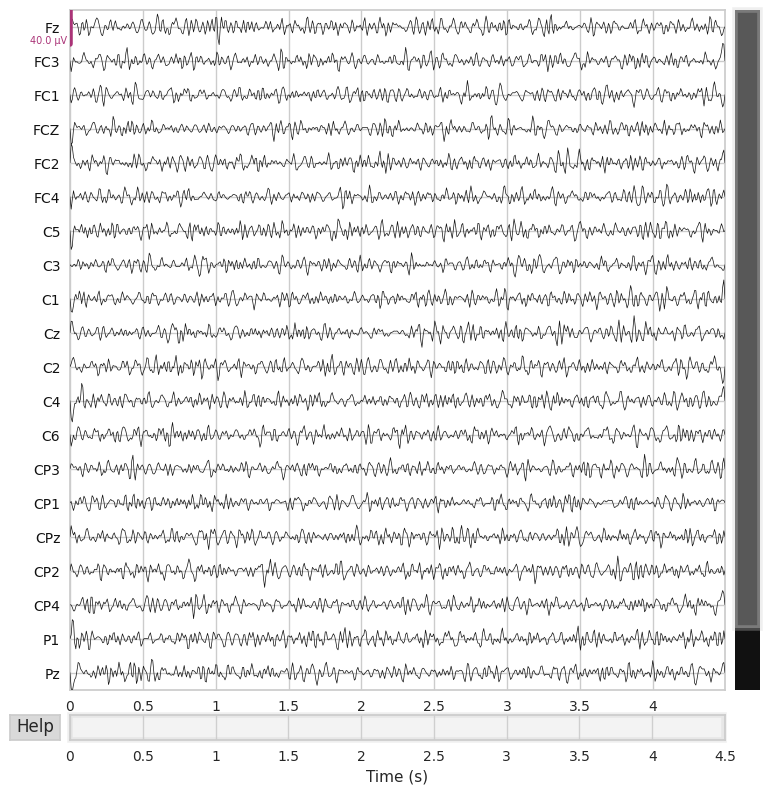

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

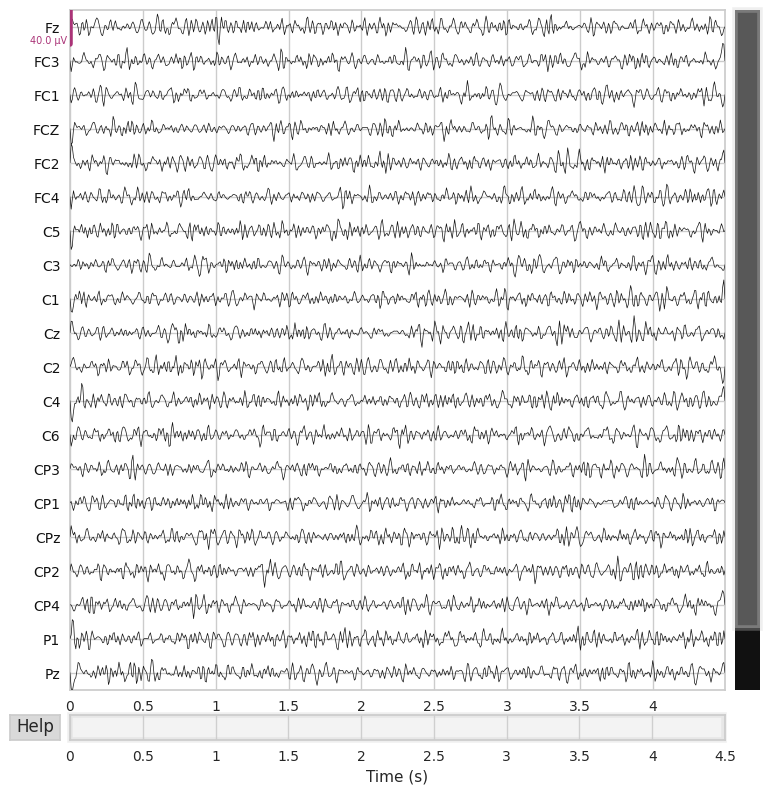

In [65]:
raw.plot()


In [66]:
preprocessors = [
                    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
                    #Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
                    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),
                    #Preprocessor('resample', sfreq=resample),
                    #Preprocessor(exponential_moving_standardize,  # Exponential movin standardization
                               # factor_new=factor_new,
                               #  init_block_size=init_block_size)
                    ]
dataset = MOABBDataset(dataset_name="BNCI2014001", subject_ids= 1)
preprocess(dataset, preprocessors)
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
print(sfreq)
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)
splitted = windows_dataset.split('session')
train_set = splitted['session_T']
valid_set = splitted['session_E']

input_window_samples = train_set[0][0].shape[1]
X_train,y_train = extrack_dataset(train_set)

250.0
(288, 22, 1125)


In [67]:
ch_names = ["Fz",
 'FC3','FC1','FCZ','FC2','FC4',
 'C5','C3','C1','Cz','C2','C4','C6',
 'CP3','CP1','CPz','CP2','CP4',
 'P1','Pz','P2',
 'POZ'
 ]

In [68]:
info = mne.create_info(ch_names, 250., ch_types='eeg', verbose=None)
raw = mne.io.RawArray(X_train[3],info)
#raw.pick_channels(['C3', 'C4'])

In [69]:
print(raw)
print(raw.info)

<RawArray | 22 x 1125 (4.5 s), ~219 kB, data loaded>
<Info | 7 non-empty values
 bads: []
 ch_names: Fz, FC3, FC1, FCZ, FC2, FC4, C5, C3, C1, Cz, C2, C4, C6, CP3, ...
 chs: 22 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 22
 projs: []
 sfreq: 250.0 Hz
>


findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

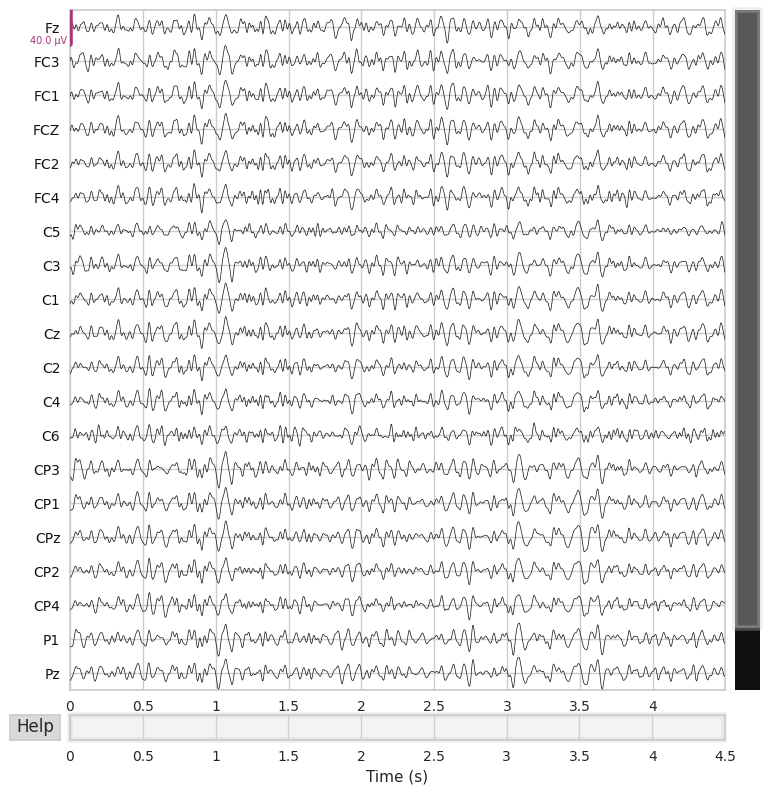

findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Generic family 'sans-serif' not found because none of the fo

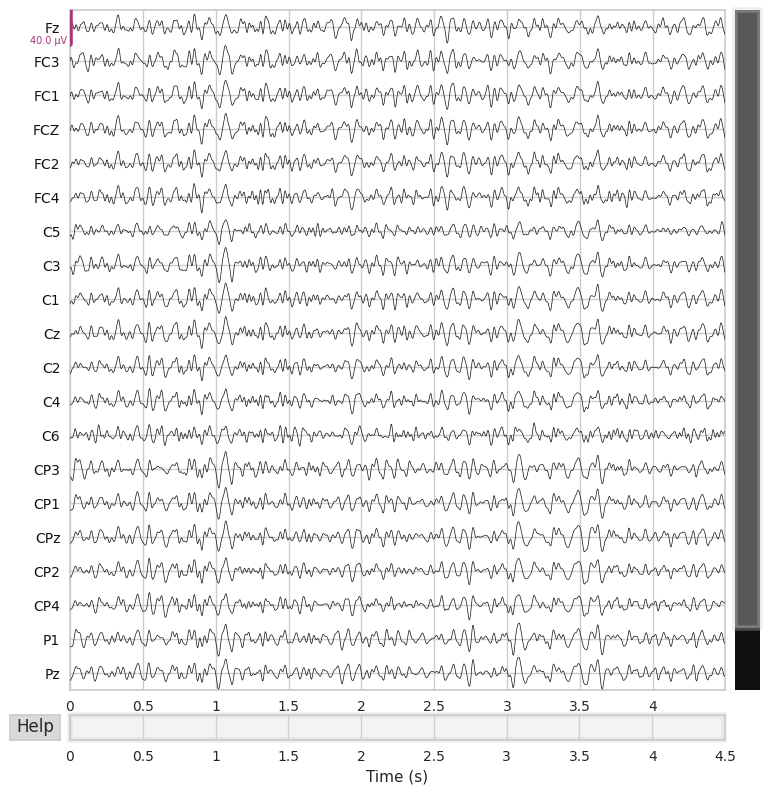

In [70]:
raw.plot()

In [71]:
valid_set = splitted['session_E']